In [11]:
from rdflib import Graph, Literal, RDF, URIRef, BNode, Namespace
from rdflib.namespace import XSD

# Create a namespace
ex = Namespace("http://example.org/")

# Create a graph
g = Graph()
g.bind('ex', ex)

# Define multiple triples
triples = [
    (ex.Subject1, ex.likes, ex.ObjectA),
    (ex.Subject2, ex.dislikes, ex.ObjectB),
    (ex.Subject3, ex.knows, ex.Subject1),
    (ex.Subject4, ex.created, ex.ObjectC)
]

# Add the triples to the graph
for s, p, o in triples:
    g.add((s, p, o))

# Reify the triples with metadata
for idx, (s, p, o) in enumerate(triples, start=1):
    # Create a unique URI for the reified statement
    statement_uri = URIRef(f"http://example.org/statement/{idx}")
    
    # Declare that the statement URI is of type rdf:Statement
    g.add((statement_uri, RDF.type, RDF.Statement))
    
    # Add the rdf:subject, rdf:predicate, and rdf:object properties to the statement
    g.add((statement_uri, RDF.subject, s))
    g.add((statement_uri, RDF.predicate, p))
    g.add((statement_uri, RDF.object, o))
    
    # Add metadata about the statement
    # For example, who asserted the statement and when
    g.add((statement_uri, ex.assertedBy, URIRef(f"http://example.org/Person{idx}")))
    g.add((statement_uri, ex.assertionDate, Literal(f"2023-10-{idx:02d}", datatype=XSD.date)))
    g.add((statement_uri, ex.confidenceScore, Literal(0.8 + idx * 0.05)))
    g.add((statement_uri, ex.comment, Literal(f"This is statement number {idx}.")))

# Serialize the graph to see the output
print(g.serialize(format='turtle'))


@prefix ex: <http://example.org/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://example.org/statement/1> a rdf:Statement ;
    ex:assertedBy ex:Person1 ;
    ex:assertionDate "2023-10-01"^^xsd:date ;
    ex:comment "This is statement number 1." ;
    ex:confidenceScore 8.5e-01 ;
    rdf:object ex:ObjectA ;
    rdf:predicate ex:likes ;
    rdf:subject ex:Subject1 .

<http://example.org/statement/2> a rdf:Statement ;
    ex:assertedBy ex:Person2 ;
    ex:assertionDate "2023-10-02"^^xsd:date ;
    ex:comment "This is statement number 2." ;
    ex:confidenceScore 9e-01 ;
    rdf:object ex:ObjectB ;
    rdf:predicate ex:dislikes ;
    rdf:subject ex:Subject2 .

<http://example.org/statement/3> a rdf:Statement ;
    ex:assertedBy ex:Person3 ;
    ex:assertionDate "2023-10-03"^^xsd:date ;
    ex:comment "This is statement number 3." ;
    ex:confidenceScore 9.5e-01 ;
    rdf:object ex:Subject1 ;
    rdf:predicate ex:

In [12]:
from rdflib.plugins.sparql import prepareQuery

query = prepareQuery('''
    SELECT ?subject ?predicate ?object
    WHERE {
        ?statement rdf:type rdf:Statement ;
                   rdf:subject ?subject ;
                   rdf:predicate ?predicate ;
                   rdf:object ?object ;
                   ex:assertedBy ex:Person1 .
    }
''', initNs={'rdf': RDF, 'ex': ex})

for row in g.query(query):
    print(f"{row.subject} {row.predicate} {row.object}")


http://example.org/Subject1 http://example.org/likes http://example.org/ObjectA


In [13]:
from rdflib import Graph, Literal, RDF, URIRef, Namespace
from rdflib.namespace import XSD

# Create a namespace
ex = Namespace("http://example.org/")

# Create a graph
g = Graph()
g.bind('ex', ex)

# Define the main triple
subject = ex.Event
predicate = ex.hasDate
obj = Literal("2023-10-01", datatype=XSD.date)

# Add the main triple to the graph
g.add((subject, predicate, obj))

# Reify the triple with conflicting statements

# First statement
statement1 = URIRef("http://example.org/statement/1")
g.add((statement1, RDF.type, RDF.Statement))
g.add((statement1, RDF.subject, subject))
g.add((statement1, RDF.predicate, predicate))
g.add((statement1, RDF.object, Literal("2023-10-01", datatype=XSD.date)))
g.add((statement1, ex.assertedBy, ex.SourceA))
g.add((statement1, ex.confidence, Literal(0.9)))
g.add((statement1, ex.comment, Literal("First reported date.")))

# Second conflicting statement
statement2 = URIRef("http://example.org/statement/2")
g.add((statement2, RDF.type, RDF.Statement))
g.add((statement2, RDF.subject, subject))
g.add((statement2, RDF.predicate, predicate))
g.add((statement2, RDF.object, Literal("2023-10-05", datatype=XSD.date)))  # Different date
g.add((statement2, ex.assertedBy, ex.SourceB))
g.add((statement2, ex.confidence, Literal(0.85)))
g.add((statement2, ex.comment, Literal("Updated event date.")))

# Serialize the graph
print(g.serialize(format='turtle'))


@prefix ex: <http://example.org/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://example.org/statement/1> a rdf:Statement ;
    ex:assertedBy ex:SourceA ;
    ex:comment "First reported date." ;
    ex:confidence 9e-01 ;
    rdf:object "2023-10-01"^^xsd:date ;
    rdf:predicate ex:hasDate ;
    rdf:subject ex:Event .

<http://example.org/statement/2> a rdf:Statement ;
    ex:assertedBy ex:SourceB ;
    ex:comment "Updated event date." ;
    ex:confidence 8.5e-01 ;
    rdf:object "2023-10-05"^^xsd:date ;
    rdf:predicate ex:hasDate ;
    rdf:subject ex:Event .

ex:Event ex:hasDate "2023-10-01"^^xsd:date .




In [17]:
from rdflib import Graph, Literal, RDF, URIRef, Namespace
from rdflib.namespace import XSD
from rdflib.plugins.sparql import prepareQuery

# Create a namespace
ex = Namespace("http://example.org/")

# Create a graph
g = Graph()
g.bind('ex', ex)

# Define the main triple with instances as subject and object
subject = ex.PersonA
predicate = ex.isFriendOf
obj = ex.PersonB

# Add the main triple to the graph
g.add((subject, predicate, obj))

# Reify the triple with conflicting statements

# First statement
statement1 = URIRef("http://example.org/statement/1")
g.add((statement1, RDF.type, RDF.Statement))
g.add((statement1, RDF.subject, subject))
g.add((statement1, RDF.predicate, predicate))
g.add((statement1, RDF.object, obj))
g.add((statement1, ex.assertedBy, ex.Source1))
g.add((statement1, ex.confidence, Literal(0.95)))
g.add((statement1, ex.friendshipStartDate, Literal("2019-05-20", datatype=XSD.date)))
g.add((statement1, ex.comment, Literal("According to Source1, they became friends in 2019.")))

# Second conflicting statement
statement2 = URIRef("http://example.org/statement/2")
g.add((statement2, RDF.type, RDF.Statement))
g.add((statement2, RDF.subject, subject))
g.add((statement2, RDF.predicate, predicate))
g.add((statement2, RDF.object, obj))
g.add((statement2, ex.assertedBy, ex.Source2))
g.add((statement2, ex.confidence, Literal(0.8)))
g.add((statement2, ex.friendshipStartDate, Literal("2020-08-15", datatype=XSD.date)))  # Different date
g.add((statement2, ex.comment, Literal("Source2 claims they became friends in 2020.")))

# Serialize the graph
print("Graph in Turtle format:\n")
print(g.serialize(format='turtle'))

# Prepare the SPARQL query
query = prepareQuery('''
    SELECT ?source ?confidence ?startDate
    WHERE {
        ?statement rdf:type rdf:Statement ;
                   rdf:subject ex:PersonA ;
                   rdf:predicate ex:isFriendOf ;
                   rdf:object ex:PersonB ;
                   ex:assertedBy ?source ;
                   ex:confidence ?confidence ;
                   ex:friendshipStartDate ?startDate .
    }
''', initNs={'rdf': RDF, 'ex': ex})

# Execute the query
print("\nSPARQL Query Results:\n")
for row in g.query(query):
    source = row.source
    confidence = row.confidence.toPython()
    start_date = row.startDate.toPython()
    print(f"Source: {source}, Confidence: {confidence}, Friendship Start Date: {start_date}")


Graph in Turtle format:

@prefix ex: <http://example.org/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://example.org/statement/1> a rdf:Statement ;
    ex:assertedBy ex:Source1 ;
    ex:comment "According to Source1, they became friends in 2019." ;
    ex:confidence 9.5e-01 ;
    ex:friendshipStartDate "2019-05-20"^^xsd:date ;
    rdf:object ex:PersonB ;
    rdf:predicate ex:isFriendOf ;
    rdf:subject ex:PersonA .

<http://example.org/statement/2> a rdf:Statement ;
    ex:assertedBy ex:Source2 ;
    ex:comment "Source2 claims they became friends in 2020." ;
    ex:confidence 8e-01 ;
    ex:friendshipStartDate "2020-08-15"^^xsd:date ;
    rdf:object ex:PersonB ;
    rdf:predicate ex:isFriendOf ;
    rdf:subject ex:PersonA .

ex:PersonA ex:isFriendOf ex:PersonB .



SPARQL Query Results:

Source: http://example.org/Source1, Confidence: 0.95, Friendship Start Date: 2019-05-20
Source: http://example.org/Source2,

In [19]:
from rdflib import Graph, Literal, RDF, URIRef, Namespace
from rdflib.namespace import XSD
from rdflib.plugins.sparql import prepareQuery
from datetime import date

# Create a namespace
ex = Namespace("http://example.org/")

# Create a graph
g = Graph()
g.bind('ex', ex)

# Define the main triple with instances as subject and object
subject = ex.PersonA
predicate = ex.isFriendOf
obj = ex.PersonB

# Add the main triple to the graph
g.add((subject, predicate, obj))

# Reify the triple with conflicting statements

# First statement (before 2020-01-01)
statement1 = URIRef("http://example.org/statement/1")
g.add((statement1, RDF.type, RDF.Statement))
g.add((statement1, RDF.subject, subject))
g.add((statement1, RDF.predicate, predicate))
g.add((statement1, RDF.object, obj))
g.add((statement1, ex.assertedBy, ex.Source1))
g.add((statement1, ex.confidence, Literal(0.95)))
g.add((statement1, ex.friendshipStartDate, Literal("2019-05-20", datatype=XSD.date)))
g.add((statement1, ex.comment, Literal("According to Source1, they became friends in 2019.")))

# Second conflicting statement (after 2020-01-01)
statement2 = URIRef("http://example.org/statement/2")
g.add((statement2, RDF.type, RDF.Statement))
g.add((statement2, RDF.subject, subject))
g.add((statement2, RDF.predicate, predicate))
g.add((statement2, RDF.object, obj))
g.add((statement2, ex.assertedBy, ex.Source2))
g.add((statement2, ex.confidence, Literal(0.8)))
g.add((statement2, ex.friendshipStartDate, Literal("2020-08-15", datatype=XSD.date)))  # Different date
g.add((statement2, ex.comment, Literal("Source2 claims they became friends in 2020.")))

# Serialize the graph
print("Graph in Turtle format:\n")
print(g.serialize(format='turtle'))

# Prepare the SPARQL query to retrieve statements with friendshipStartDate after 2020-01-01
query = prepareQuery('''
    SELECT ?statement ?source ?confidence ?startDate
    WHERE {
        ?statement rdf:type rdf:Statement ;
                   rdf:subject ex:PersonA ;
                   rdf:predicate ex:isFriendOf ;
                   rdf:object ex:PersonB ;
                   ex:assertedBy ?source ;
                   ex:confidence ?confidence ;
                   ex:friendshipStartDate ?startDate .
        FILTER(?startDate > "2020-01-01"^^xsd:date)
    }
''', initNs={'rdf': RDF, 'ex': ex, 'xsd': XSD})

# Execute the query
print("\nSPARQL Query Results:\n")
for row in g.query(query):
    statement = row.statement
    source = row.source
    confidence = row.confidence.toPython()
    start_date = row.startDate.toPython()
    print(f"Statement: {statement}, Source: {source}, Confidence: {confidence}, Friendship Start Date: {start_date}")

# Alternative approach with dynamic date input
# Define the threshold date
threshold_date = date(2020, 1, 1)

# Convert the date to an xsd:date Literal
threshold_literal = Literal(threshold_date.isoformat(), datatype=XSD.date)

# Prepare the SPARQL query with a variable for the date
query_dynamic = prepareQuery('''
    SELECT ?statement ?source ?confidence ?startDate
    WHERE {
        ?statement rdf:type rdf:Statement ;
                   rdf:subject ex:PersonA ;
                   rdf:predicate ex:isFriendOf ;
                   rdf:object ex:PersonB ;
                   ex:assertedBy ?source ;
                   ex:confidence ?confidence ;
                   ex:friendshipStartDate ?startDate .
        FILTER(?startDate > ?thresholdDate)
    }
''', initNs={'rdf': RDF, 'ex': ex, 'xsd': XSD})

# Execute the query with the threshold date bound to ?thresholdDate
print("\nSPARQL Query Results with Dynamic Date:\n")
for row in g.query(query_dynamic, initBindings={'thresholdDate': threshold_literal}):
    statement = row.statement
    source = row.source
    confidence = row.confidence.toPython()
    start_date = row.startDate.toPython()
    print(f"Statement: {statement}, Source: {source}, Confidence: {confidence}, Friendship Start Date: {start_date}")


Graph in Turtle format:

@prefix ex: <http://example.org/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://example.org/statement/1> a rdf:Statement ;
    ex:assertedBy ex:Source1 ;
    ex:comment "According to Source1, they became friends in 2019." ;
    ex:confidence 9.5e-01 ;
    ex:friendshipStartDate "2019-05-20"^^xsd:date ;
    rdf:object ex:PersonB ;
    rdf:predicate ex:isFriendOf ;
    rdf:subject ex:PersonA .

<http://example.org/statement/2> a rdf:Statement ;
    ex:assertedBy ex:Source2 ;
    ex:comment "Source2 claims they became friends in 2020." ;
    ex:confidence 8e-01 ;
    ex:friendshipStartDate "2020-08-15"^^xsd:date ;
    rdf:object ex:PersonB ;
    rdf:predicate ex:isFriendOf ;
    rdf:subject ex:PersonA .

ex:PersonA ex:isFriendOf ex:PersonB .



SPARQL Query Results:

Statement: http://example.org/statement/2, Source: http://example.org/Source2, Confidence: 0.8, Friendship Start Date: 2020

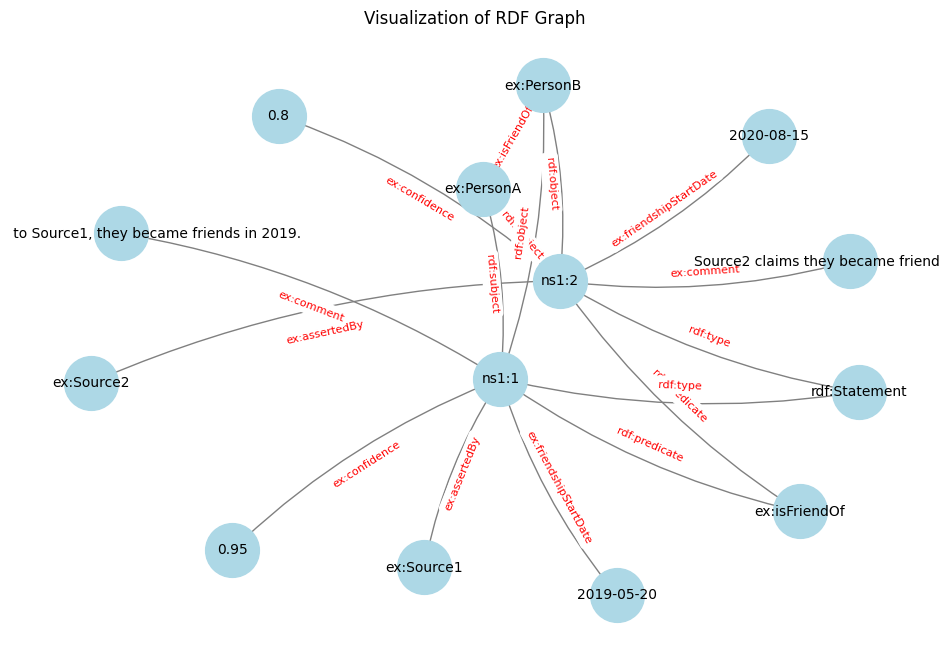

In [21]:
import rdflib
from rdflib import Graph, Literal, RDF, URIRef, Namespace
from rdflib.namespace import XSD
import networkx as nx
import matplotlib.pyplot as plt

# Create a namespace
ex = Namespace("http://example.org/")

# Create a graph
g = Graph()
g.bind('ex', ex)

# Define the main triple with instances as subject and object
subject = ex.PersonA
predicate = ex.isFriendOf
obj = ex.PersonB

# Add the main triple to the graph
g.add((subject, predicate, obj))

# Reify the triple with conflicting statements

# First statement (before 2020-01-01)
statement1 = URIRef("http://example.org/statement/1")
g.add((statement1, RDF.type, RDF.Statement))
g.add((statement1, RDF.subject, subject))
g.add((statement1, RDF.predicate, predicate))
g.add((statement1, RDF.object, obj))
g.add((statement1, ex.assertedBy, ex.Source1))
g.add((statement1, ex.confidence, Literal(0.95)))
g.add((statement1, ex.friendshipStartDate, Literal("2019-05-20", datatype=XSD.date)))
g.add((statement1, ex.comment, Literal("According to Source1, they became friends in 2019.")))

# Second conflicting statement (after 2020-01-01)
statement2 = URIRef("http://example.org/statement/2")
g.add((statement2, RDF.type, RDF.Statement))
g.add((statement2, RDF.subject, subject))
g.add((statement2, RDF.predicate, predicate))
g.add((statement2, RDF.object, obj))
g.add((statement2, ex.assertedBy, ex.Source2))
g.add((statement2, ex.confidence, Literal(0.8)))
g.add((statement2, ex.friendshipStartDate, Literal("2020-08-15", datatype=XSD.date)))  # Different date
g.add((statement2, ex.comment, Literal("Source2 claims they became friends in 2020.")))

# Convert RDFLib graph to NetworkX graph
G = nx.MultiDiGraph()

for s, p, o in g:
    G.add_edge(s, o, label=g.qname(p))

# Set labels for nodes
labels = {}
for node in G.nodes():
    if isinstance(node, URIRef):
        labels[node] = g.qname(node)
    elif isinstance(node, Literal):
        labels[node] = str(node)
    else:
        labels[node] = str(node)

# Draw the graph
plt.figure(figsize=(12, 8))

pos = nx.spring_layout(G, k=0.5, iterations=50)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='lightblue')

# Draw edges
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='gray', connectionstyle='arc3,rad=0.1')

# Draw node labels
nx.draw_networkx_labels(G, pos, labels, font_size=10)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8, label_pos=0.5)

plt.axis('off')
plt.title('Visualization of RDF Graph')
plt.show()
